### Import Dependencies

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

import privacy.optimizers.dp_optimizer as optimizers
from privacy.analysis.rdp_accountant import compute_rdp
from privacy.analysis.rdp_accountant import get_privacy_spent
from privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer, DPAdamOptimizer
from privacy.dp_query.gaussian_query import GaussianAverageQuery, GaussianSumQuery

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

### 1. Data exploration

In [10]:
# Loading Data
df_full = pd.read_csv('./data/UCI_Credit_Card.csv')

In [11]:
df_full

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [12]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_AMT4                     30000 non-null float64
BILL_AMT5                     30000 non-null float64
BILL_AMT6   

In [13]:
#df_fullna = df_full.replace('?', np.nan) 

In [16]:
df_full.isnull().sum() # No Missing values

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

### Quick check for value range

In [18]:
df_full.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


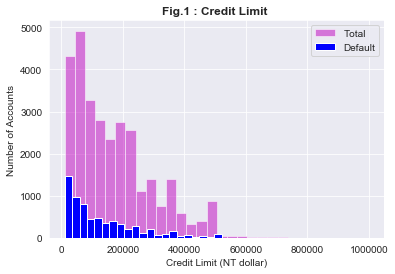

In [19]:
# Credit Limit (Feature name :'LIMIT_BAL' )
%matplotlib inline
bins = 30
plt.hist(data.LIMIT_BAL, bins = bins, color='m',label = 'Total',alpha=0.5)
plt.hist(data.LIMIT_BAL[data['default.payment.next.month'] == 1], bins = bins, color='b',label = 'Default')

plt.xlabel('Credit Limit (NT dollar)');plt.ylabel('Number of Accounts')
plt.title('Fig.1 : Credit Limit ',fontweight="bold", size=12)
plt.legend();plt.show()

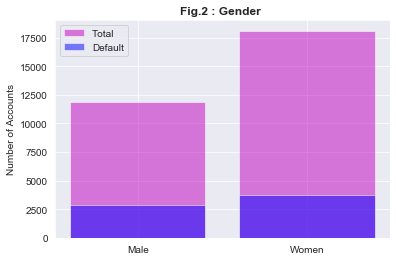

In [20]:
# Gender (Feature name :'SEX' )
men = data['SEX'][data['SEX']==1].count()
men_default = data['SEX'][(data['SEX']==1)&(data['default.payment.next.month']==1)].count()

women = data['SEX'][data['SEX']==2].count()
women_default = data['SEX'][(data['SEX']==2)&(data['default.payment.next.month']==1)].count()

total_sex = [men, women]
default_sex = [men_default,women_default]
gender = [1,2]
plt.bar(gender,total_sex, color='m',alpha=0.5, label='Total')
plt.bar(gender,default_sex, color='b',alpha=0.5, label='Default')

plt.xticks([1,2],['Male','Women']);plt.ylabel('Number of Accounts')
plt.title('Fig.2 : Gender ',fontweight="bold", size=12)
plt.legend();plt.show()

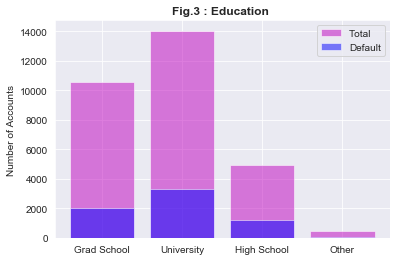

In [21]:
# Education (Feature name :'EDUCATION' )
grad =  data['EDUCATION'][data['EDUCATION']==1].count()
grad_default = data['EDUCATION'][(data['EDUCATION']==1)&(data['default.payment.next.month']==1)].count()

uni =  data['EDUCATION'][data['EDUCATION']==2].count()
uni_default = data['EDUCATION'][(data['EDUCATION']==2)&(data['default.payment.next.month']==1)].count()

high =  data['EDUCATION'][data['EDUCATION']==3].count()
high_default = data['EDUCATION'][(data['EDUCATION']==3)&(data['default.payment.next.month']==1)].count()

other =  data['EDUCATION'][data['EDUCATION'] > 3].count()
other_default = data['EDUCATION'][(data['EDUCATION'] > 3)&(data['default.payment.next.month']==1)].count()

total_education = [grad, uni, high, other]
default_education = [grad_default,uni_default,high_default, other_default]
degree = [1,2,3,4]
plt.bar(degree,total_education, color='m',alpha=0.5, label='Total')
plt.bar(degree,default_education, color='b',alpha=0.5, label='Default')

plt.xticks([1,2,3,4],['Grad School','University','High School','Other'])
plt.ylabel('Number of Accounts');plt.title('Fig.3 : Education ',fontweight="bold", size=12)
plt.legend();plt.show()

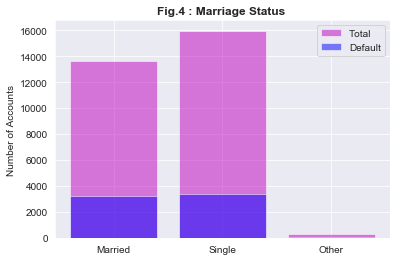

In [22]:
# Marriage Status (Feature name :'MARRIAGE')
married =  data['MARRIAGE'][data['MARRIAGE']==1].count()
married_default = data['MARRIAGE'][(data['MARRIAGE']==1)&(data['default.payment.next.month']==1)].count()

single =  data['MARRIAGE'][data['MARRIAGE']==2].count()
single_default = data['MARRIAGE'][(data['MARRIAGE']==2)&(data['default.payment.next.month']==1)].count()

other =  data['MARRIAGE'][data['MARRIAGE']==3].count()
other_default = data['MARRIAGE'][(data['MARRIAGE']==3)&(data['default.payment.next.month']==1)].count()

total_marriage = [married, single, other]
default_marriage = [married_default,single_default,other_default]
status = [1,2,3]
plt.bar(status,total_marriage, color='m',alpha=0.5, label='Total')
plt.bar(status,default_marriage, color='b',alpha=0.5, label='Default')

plt.xticks([1,2,3],['Married','Single','Other']); plt.ylabel('Number of Accounts')
plt.title('Fig.4 : Marriage Status ',fontweight="bold", size=12)
plt.legend(); plt.show()

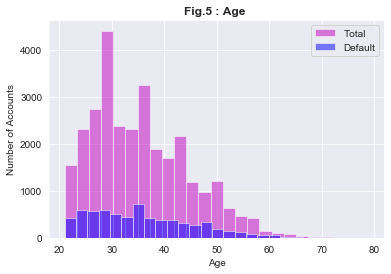

In [23]:
# Age (Feature name :'AGE' )
bins = 25

plt.hist(data['AGE'],bins = bins, color='m',label = 'Total',alpha=0.5)
plt.hist(data['AGE'][data['default.payment.next.month']==1], bins = bins, color='b',label = 'Default',alpha=0.5)

plt.xlabel('Age'); plt.ylabel('Number of Accounts')
plt.title('Fig.5 : Age ',fontweight="bold", size=12)
plt.legend();plt.show()

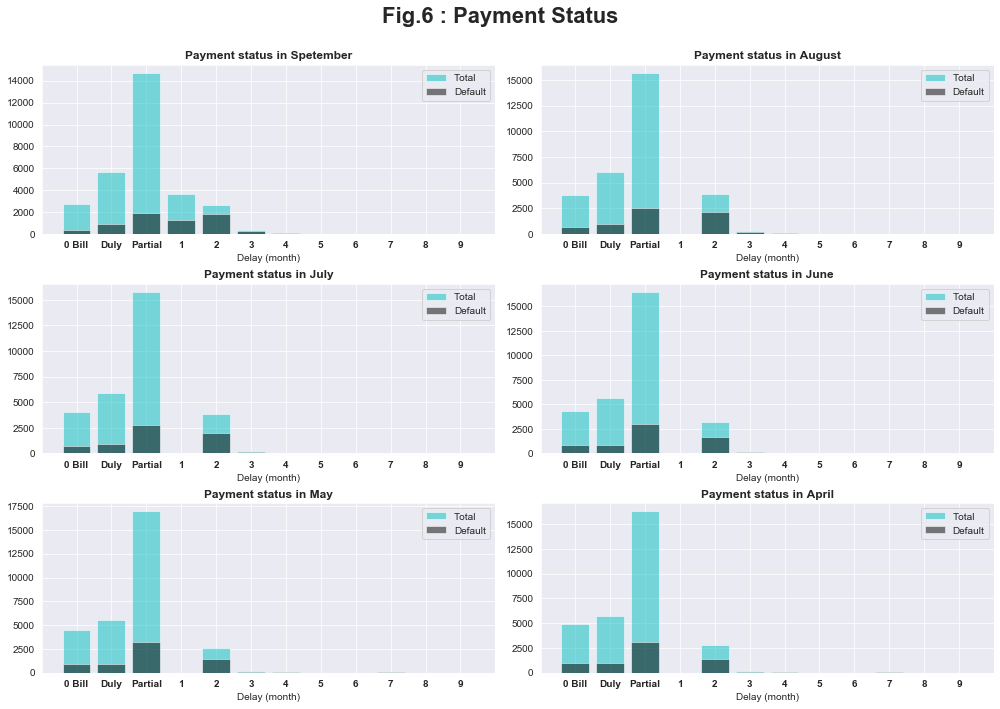

In [24]:
# Payment status (Feature name :'PAY_' )
import matplotlib.gridspec as gridspec
features = list(data.columns)
plt.figure(figsize=(14,10))

gs = gridspec.GridSpec(3,2)
i = 0

plt.suptitle('Fig.6 : Payment Status',fontweight="bold", fontsize=22)
for cn in features[6:12]:
    ax = plt.subplot(gs[i])
    delay = np.zeros(12)
    delay_default = np.zeros(12)  
    for j in np.arange(0,12):
            delay[j] = data[cn][data[cn]==j-2].count()
            delay_default[j] = data[cn][(data[cn]==j-2)&(data['default.payment.next.month']==1)].count()  

    month = [-2,-1,0,1,2,3,4,5,6,7,8,9]
    plt.bar(month,delay, color='c',alpha=0.5, label='Total')
    plt.bar(month,delay_default, color='k',alpha=0.5, label='Default')

    plt.xticks([-2,-1,0,1,2,3,4,5,6,7,8,9],['0 Bill','Duly','Partial','1','2','3','4','5','6','7','8','9'], fontweight="bold", size=10)
    ax.set_xlabel('Delay (month)')
    months = ['Spetember','August','July','June','May','April']
    ax.set_title('Payment status in ' + months[i], fontweight="bold", size=12)
    ax.legend()
    i+=1
    
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

### Note: 
Based on metadata description, -1 indicates 'pay duly', whereas 1-9 show months of payment delay. However, further exploration reveals that value of -2 is associated with zero bill amount and value 0 is associated with partial bill payment. As above figure clearly demonstrate, these two attributes are among the largest categories and shouldn't be overlooked.    


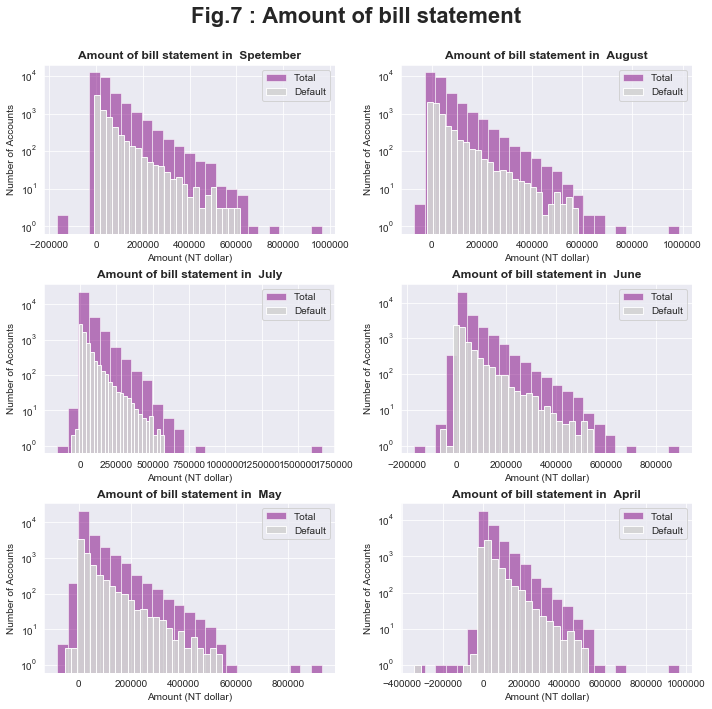

In [25]:
# Amount of bill statement (Feature name :'BILL_AMT_' )

features = list(data.columns)
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,2)
i = 0
plt.suptitle('Fig.7 : Amount of bill statement',fontweight="bold", fontsize=22)
for cn in features[12:18]:
    ax = plt.subplot(gs[i])
    bins = 25
    plt.hist(data[cn],bins = bins, color='purple',label = 'Total',alpha=0.5)
    plt.hist(data[cn][data['default.payment.next.month']==1], bins = bins, color='lightgray',label = 'Default',alpha=0.9)

    plt.xlabel('Amount (NT dollar)')
    plt.ylabel('Number of Accounts')
    ax.set_yscale('log', nonposy='clip')

    months = ['Spetember','August','July','June','May','April']
    ax.set_title('Amount of bill statement in  ' + months[i], fontweight="bold", size=12)
    ax.legend()
    i+=1  
    plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

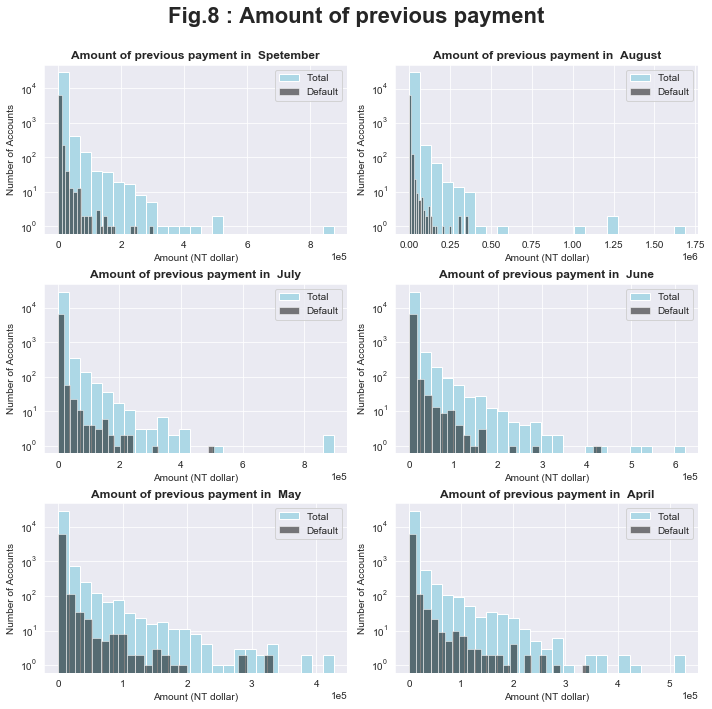

In [26]:
# Amount of previous payment (Feature name :'PAY_AMT_' )
features = list(data.columns)
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,2)
i = 0
plt.suptitle('Fig.8 : Amount of previous payment',fontweight="bold", fontsize=22)
for cn in features[18:24]:
    ax = plt.subplot(gs[i])
    bins = 25
    plt.hist(data[cn],bins = bins, color='lightblue',label = 'Total',alpha=1)
    plt.hist(data[cn][data['default.payment.next.month']==1], bins = bins, color='k',label = 'Default',alpha=0.5)

    plt.xlabel('Amount (NT dollar)')
    plt.ylabel('Number of Accounts')
    ax.set_yscale('log', nonposy='clip')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    months = ['Spetember','August','July','June','May','April']
    ax.set_title('Amount of previous payment in  ' + months[i], fontweight="bold", size=12)
    ax.legend()
    i+=1      
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

Notice that figure 7 and 8 are on log scale and most of the time, there is at least one order of magnitude difference between total value and default's.

# 3. Feature Engineering
Calculating pair correlation coefficient helps to understand nature of feature's interaction with each other and final label. One can use the seaborn heat map to better visualize these coefficients.


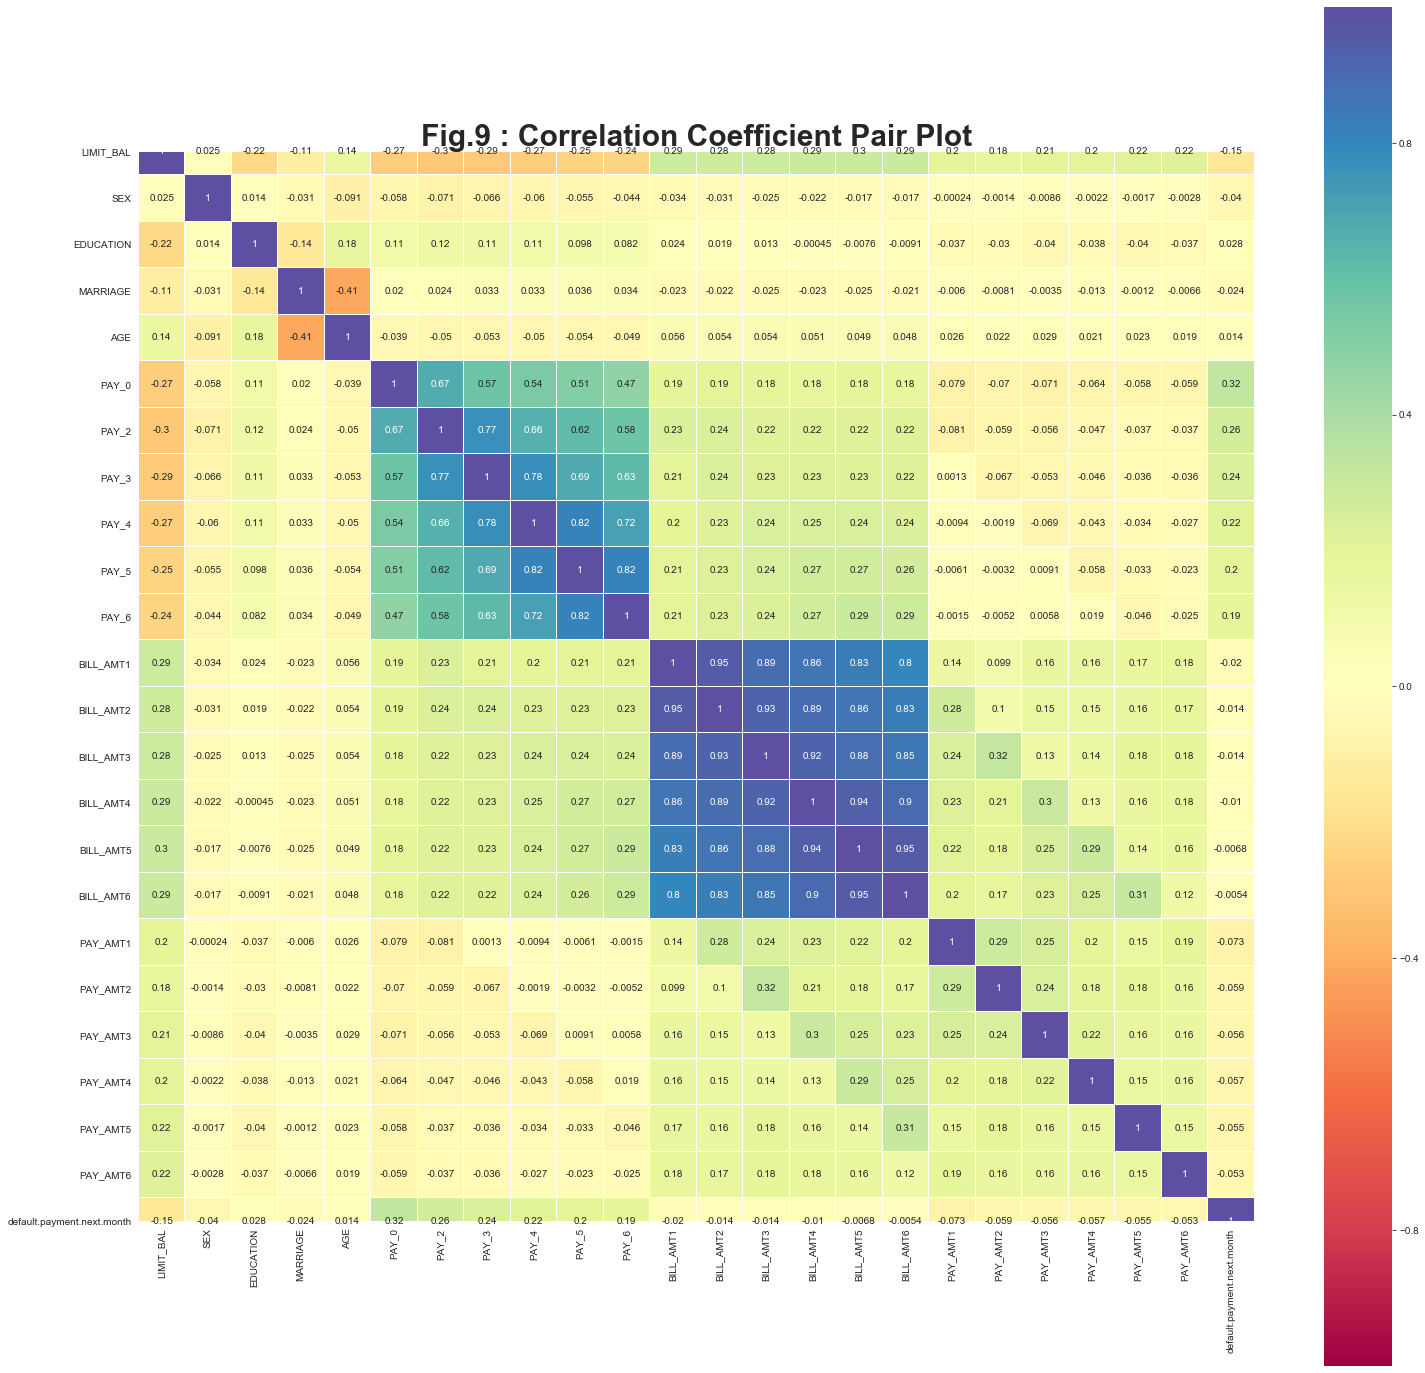

In [27]:
# Making correlation coefficients pair plot of all feature in order to identify degenrate features
plt.figure(figsize=(25,25))
ax = plt.axes()
corr = data.drop(['ID'], axis=1).corr()
sns.heatmap(corr, vmax=1,vmin=-1, square=True, annot=True, cmap='Spectral',linecolor="white", linewidths=0.01, ax=ax)
ax.set_title('Fig.9 : Correlation Coefficient Pair Plot',fontweight="bold", size=30)
plt.show()

Figure 9 shows that while features associated with bill amount ('BILL_AMT') are highly correlated to each other, yet have minimum contribution to target label ('default.payment.next.month'). In a case that computational resource is limited, one can drop these features without losing significant prediction power. 

Payment status ('PAY' ) features are also correlated but at the same time they show highest contribution to the final label. The last column clearly demonstrates that by getting closer to current month the significant of payment status increases.   

The negative correlation of 'SEX' and 'MARRIAGE' is also interesting and could be used for generating new feature but at this work, all these features remain intact and will be directly used in deep learning model.


In [29]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

predictors = data.drop(['ID','default.payment.next.month'], axis=1).as_matrix()
predictors = StandardScaler().fit_transform(predictors)

target = to_categorical(data['default.payment.next.month']) 

/Users/Srivatsa/Desktop/Tutorials & Notes/Y4S1/ISM/code/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


### 4.a  Model designing/training/visualization

In [33]:
# Calculating default Ratio
non_default = len(data[data['default.payment.next.month']==0])
default = len(data[data['default.payment.next.month']==1])
ratio = float(default/(non_default+default))
print('Default Ratio :',ratio)

Default Ratio : 0.2212


Here, it is evident that the default class appears in only 22%, which results in imbalance data. As described below, this issue can be addressed by imposing proportional weight loss, while fitting the model.

## 4.1 Model Specification

input_shape : Number of input nodes (n_cols).

Model Type : Sequential (Each layer is only in direct contact with the next layer).

Dense Layers : Each node in current layer is in contact with all nodes in the next layer.

Activation : Activation function between the layers ( 'relu' for regression and  'softmax' for classification)
                    softmax produces total probability equals to one so that can be used for classification.    

## 4.2 Compiling the Model

optimaizer : Adjust learning rate  to its optimum  value for gradient decent ( 'adam' ).

Loss : Defines loss function ( 'categorical_crossentropy' for classification and 'mean_squared_error' for regression).

## 4.3 Fitting the Model 

early_stopping_monitor : Stop training when validation is not improving.

patience : How many epoch can go without improving.

Validation_split : splitting the data to train and test and validating based on model performance on test data-set

Class Weight: Forces algorithm to treat imbalance data proportionally 


In [38]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 75)                1800      
_________________________________________________________________
dropout_51 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 50)                3800      
_________________________________________________________________
dropout_52 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 2)                 102       
Total params: 5,702
Trainable params: 5,702
Non-trainable params: 0
_________________________________________________________________
None
Train on 21000 samples, validate on 9000 samples
Epoch 1/20
21000/21000 [==============================] - 1s 37

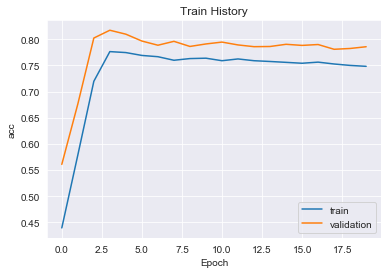

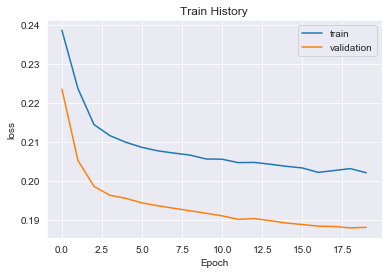

In [72]:
n_cols = predictors.shape[1]
#early_stopping_monitor = EarlyStopping(patience=2)
class_weight = {0:ratio, 1:1-ratio}

model = Sequential()
model.add(Dense(75, activation='relu', kernel_initializer='uniform', input_shape = (n_cols,)))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu', kernel_initializer='uniform',))
model.add(Dropout(0.5))
#model.add(Dense(20, activation='relu'))
model.add(Dense(2, kernel_initializer='uniform', 
                activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())
train_history = model.fit(predictors, target, epochs=20, batch_size=1000, validation_split=0.3,
                         class_weight=class_weight)
#visualize the loss and accuracy after each epoch
show_train_history(train_history,'acc','val_acc')
show_train_history(train_history,'loss','val_loss')

### 4.b  DP Model

In [85]:
# Hyperparameters
l2_norm_clip=1.0
noise_multiplier=1.1
num_microbatches=1
learning_rate=0.001
batch_size = 1000
num_training_samples = 21000
epochs = 20

In [89]:
def compute_epsilon(steps):
  """Computes epsilon value for given hyperparameters."""
  if noise_multiplier == 0.0:
    return float('inf')
  orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
  sampling_probability = batch_size / num_training_samples
  rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=noise_multiplier,
                    steps=steps,
                    orders=orders)
  # Delta is set to 1e-3 because Cervical cancer has ~21000 training points.
  print(get_privacy_spent(orders, rdp, target_delta=1e-5))
  return get_privacy_spent(orders, rdp, target_delta=1e-5)[0]

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 500)               12000     
_________________________________________________________________
dropout_65 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 200)               100200    
_________________________________________________________________
dropout_66 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 2)                 402       
Total params: 112,602
Trainable params: 112,602
Non-trainable params: 0
_________________________________________________________________
None
Train on 21000 samples, validate on 9000 samples
Epoch 1/20
21000/21000 [==============================] - 0

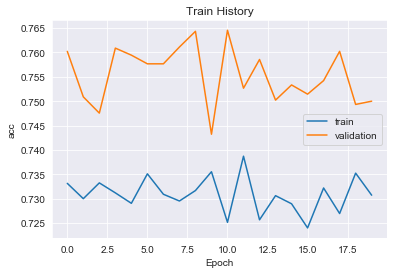

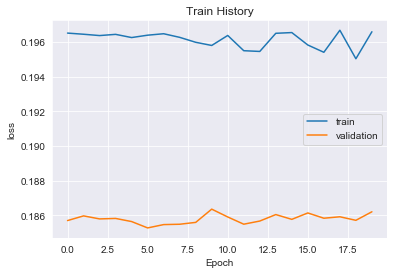

In [90]:
n_cols = predictors.shape[1]
#early_stopping_monitor = EarlyStopping(patience=2)
class_weight = {0:ratio, 1:1-ratio}

dp_model = Sequential()
dp_model.add(Dense(500, activation='relu', kernel_initializer='uniform', input_shape = (n_cols,)))
dp_model.add(Dropout(0.5))
dp_model.add(Dense(200, activation='relu', kernel_initializer='uniform',))
dp_model.add(Dropout(0.5))

dp_model.add(Dense(2, kernel_initializer='uniform', 
                activation='softmax'))

# Defining how to measure performance
'''
custom_sgd_optimizer = DPGradientDescentGaussianOptimizer(
                    l2_norm_clip=l2_norm_clip,
                    noise_multiplier=noise_multiplier,
                    num_microbatches=num_microbatches,
                    learning_rate=learning_rate)

'''
#dp_ave_query = GaussianAverageQuery(l2_norm_clip, l2_norm_clip * noise_multiplier, num_microbatches)
dp_sum_query = GaussianSumQuery(l2_norm_clip, l2_norm_clip * noise_multiplier)
custom_adam_optimizer = DPAdamOptimizer( 
                    num_microbatches=num_microbatches,
                    dp_sum_query=dp_sum_query)

dp_model.compile(optimizer=custom_adam_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
print(dp_model.summary())
train_history_dp = model.fit(predictors, target, epochs=20, batch_size=1000, validation_split=0.3,
                         class_weight=class_weight)
#visualize the loss and accuracy after each epoch
show_train_history(train_history_dp,'acc','val_acc')
show_train_history(train_history_dp,'loss','val_loss')

In [91]:
eps = compute_epsilon(epochs * num_training_samples // batch_size)
print('For delta=1e-5, the current epsilon is: %.2f' % eps)

(6.734719188396426, 1e-05, 4.2)
For delta=1e-5, the current epsilon is: 6.73


In [100]:
scores = dp_model.evaluate(predictors, target)


30000/30000 [==============================] - 1s 34us/sample - loss: 0.6893 - acc: 0.6415
